# This notebook must be run with the Vizgen_2 conda environment within the Vizgen.sif singularity container

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gseapy as gp
from tqdm import tqdm
from adjustText import adjust_text
import seaborn as sns
import anndata

from sklearn.neighbors import BallTree, KDTree
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm
from joblib import delayed, Parallel
import seaborn as sns
import os
import Mapping

from shapely.geometry import shape, box
import cv2
from skimage.measure import block_reduce
from matplotlib import patches as mpatches
from shapely.affinity import translate
import rasterio

In [2]:
def load_image_roi(file_name, window_coords):
    try:
        with rasterio.open(file_name) as aws_file:
            roi = aws_file.read(1, window=rasterio.windows.Window(*window_coords))
    except OSError:
        print(f"File read error on {file_name}")
        roi = np.zeros([window_coords[3],window_coords[2]])
        
    return np.squeeze(roi)

def convert_eight_bit(img):
    # Normalize contrast before reducing bit depth
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    norm_img = clahe.apply(img)    
    bg_subtract = norm_img - norm_img.min()
    
    if bg_subtract.max() == 0:
        return np.zeros(img.shape, dtype=np.uint8)
    else:
        range_norm = bg_subtract / bg_subtract.max()      
        return np.array(range_norm * 255, dtype=np.uint8)
def add_scale_bar(ax, conversion_rate, micron_length, color='red', location=(10, 10), thickness=50, fontsize=12):
    """
    Add a scale bar to the given axis.

    Args:
    - ax: The axis on which to draw the scale bar.
    - conversion_rate: The pixel-to-micron conversion factor (pixels per micron).
    - micron_length: The length of the scale bar in microns.
    - color: The color of the scale bar.
    - location: A tuple specifying the (x, y) location of the scale bar.
    - thickness: The thickness of the scale bar in pixels.
    """
    # Calculate the length of the scale bar in pixels
    pixel_length = conversion_rate * micron_length
    
    # Create a rectangle for the scale bar
    scale_bar = mpatches.Rectangle(location, pixel_length, thickness, linewidth=0, edgecolor=color, facecolor=color)
    
    # Add the scale bar to the plot
    ax.add_patch(scale_bar)
    text_x = location[0] + pixel_length + 10  # Place text to the right of the scale bar
    text_y = location[1] + thickness / 2      # Vertically center the text with the scale bar
    ax.text(text_x, text_y, f'{micron_length} μm', color=color, fontsize=fontsize, va='center')

In [3]:
ad_parent = sc.read_h5ad('../03_morph_embedding/Shape_500.h5ad')
ad_parent = ad_parent[ad_parent.obs.updated_celltype == 'Microglia']
os.makedirs('supp_figures/SI_3', exist_ok=True)

ad_list = []
for batch in ad_parent.obs.batchID.unique():
    ad_viz = ad_parent[ad_parent.obs.batchID == batch].copy()
    
    total = pd.read_csv(f"transcript_out/{batch}_nuc_y_non_nuc.csv",index_col=0)
    non_nuc = pd.read_csv(f"transcript_out/{batch}_non_nuc.csv",index_col=0)
    
    ad_viz.layers['total_counts'] = total[ad_viz.var_names.intersection(total.columns)].to_numpy()
    ad_viz.layers['non_nuc_counts'] = non_nuc[ad_viz.var_names.intersection(non_nuc.columns)].to_numpy()
    
    ad_viz.layers['nuc_counts'] = ad_viz.layers['total_counts'] - ad_viz.layers['non_nuc_counts']
    
    ad_list.append(ad_viz)
    
combined_adata = anndata.concat(ad_list, axis=0)

adata = combined_adata.copy()
adata.X = adata.layers['total_counts'].copy()
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata

new_ad = adata.copy()
new_ad.X = new_ad.layers['total_counts'].copy()
sc.pp.normalize_total(new_ad, target_sum=1e4)
sc.pp.log1p(new_ad)

place_in_order = {
    0: '4',
    1: '1',
    2: '2',
    3: '0',
    4: '3',
}

new_ad.obs['ordered_morph'] = new_ad.obs.morph_leiden.map(place_in_order)

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [4]:
total = sc.read_h5ad('../02_annotation/ABC_cleaned.h5ad')
new_ad = sc.read_h5ad('Transciptomic_labels_and_morphology_labels_full.h5ad')
new_ad = new_ad[new_ad.obs.Brain_Region != 'Unlabeled']

In [5]:
root = '/hpc/projects/group.quake/doug/Shapes_Spatial/'
batch = '3-mo-male-3-rev2'
raw_im = Mapping.load_tiff_image(root + batch + '/binary_image.tif')
dapi_im = Mapping.load_tiff_image(root + batch + '/images/mosaic_DAPI_z1.tif')

In [6]:
dscale = 20
mosaic_to_micron = pd.read_csv('/hpc/projects/group.quake/doug/Shapes_Spatial/3-mo-female-1-rev2/images/micron_to_mosaic_pixel_transform.csv',delimiter=' ').iloc[0,1]
mosaic_lowres = block_reduce(dapi_im, block_size=(dscale, dscale), func=np.mean)

In [7]:
# Viewport location. Formatted as: [columndapi_imset (x), row_offset (y), width, height], units are pixels
xMin = 45000
yMin = 10000
width = 10000
height = 10000
xMax = xMin + width
yMax = yMin + height
viewport = [xMin, yMin, width, height]

green = convert_eight_bit(load_image_roi(root + batch + '/binary_image.tif', viewport))
#red = convert_eight_bit(load_image_roi(polyt_file_name, viewport))
#green = convert_eight_bit(load_image_roi(mic_file_name, viewport))


print('Viewport created.')

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Viewport created.


Viewport created.


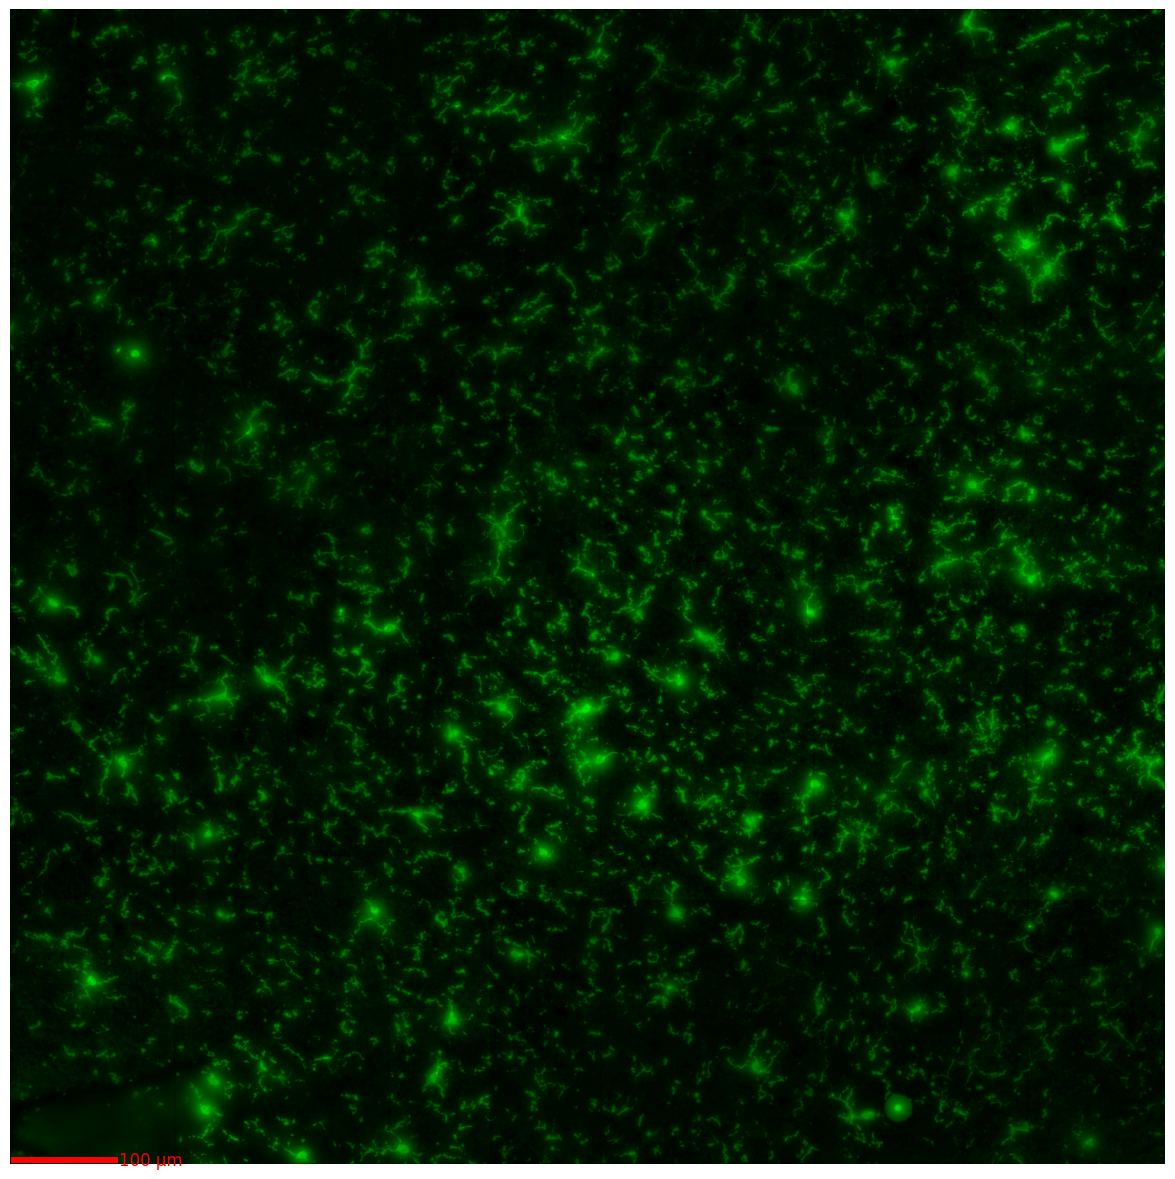

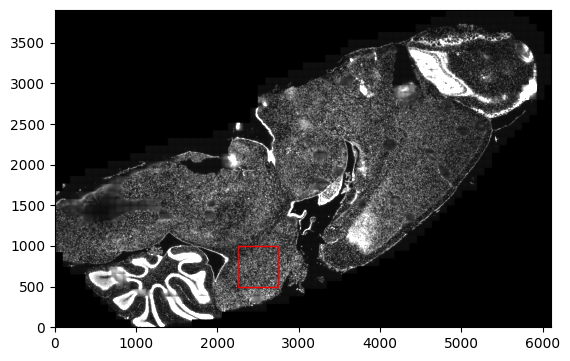

In [8]:
xMin = 45000
yMin = 10000
width = 10000
height = 10000
xMax = xMin + width
yMax = yMin + height
viewport = [xMin, yMin, width, height]

green = convert_eight_bit(load_image_roi(root + batch + '/binary_image.tif', viewport))
#red = convert_eight_bit(load_image_roi(polyt_file_name, viewport))
#green = convert_eight_bit(load_image_roi(mic_file_name, viewport))


print('Viewport created.')

fig, ax = plt.subplots(1,1, figsize=(15,15))
zero_im = np.zeros(green.shape, dtype=np.uint8)

#red = zero_im

# Sample MERFISH bit
#im = cv2.merge((red, zero_im, zero_im))
#ax[0].imshow(im, origin='lower')
#ax[0].axis("off")

# Positions of decoded transcripts + segmented boundaries
# CellBound3
im = cv2.merge((zero_im, green, zero_im))
ax.imshow(im, origin='lower')
ax.axis("off")


# DAPI
#im = cv2.merge((zero_im, zero_im, blue))
#ax[1,1].imshow(im, origin='lower')
#ax[1,1].axis("off")

#fig.savefig('SI_Figures/Baysor_example.pdf', format='pdf')
#ax.imshow(small_raw,cmap='gray')
add_scale_bar(ax, mosaic_to_micron, 100, color='red', location=(10, 10), thickness=50, fontsize=12)
plt.savefig('supp_figures/SI_3/MPM_tight.pdf')

plt.show()

# Plot the mosaic image and show the window view
globMinX, globMinY = (xMin/dscale, yMin/dscale)
globMaxX, globMaxY = (xMax/dscale, yMax/dscale)

# Create rectangle for zoomed in snippet
rect = mpatches.Rectangle((globMinX, globMinY), globMaxX - globMinX, 
                          globMaxY - globMinY, linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots()
ax.imshow(mosaic_lowres, cmap='gray', vmax=20000, origin='lower')
ax.add_patch(rect)
plt.savefig('supp_figures/SI_3/MPM_out.pdf')
plt.show()

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Viewport created.


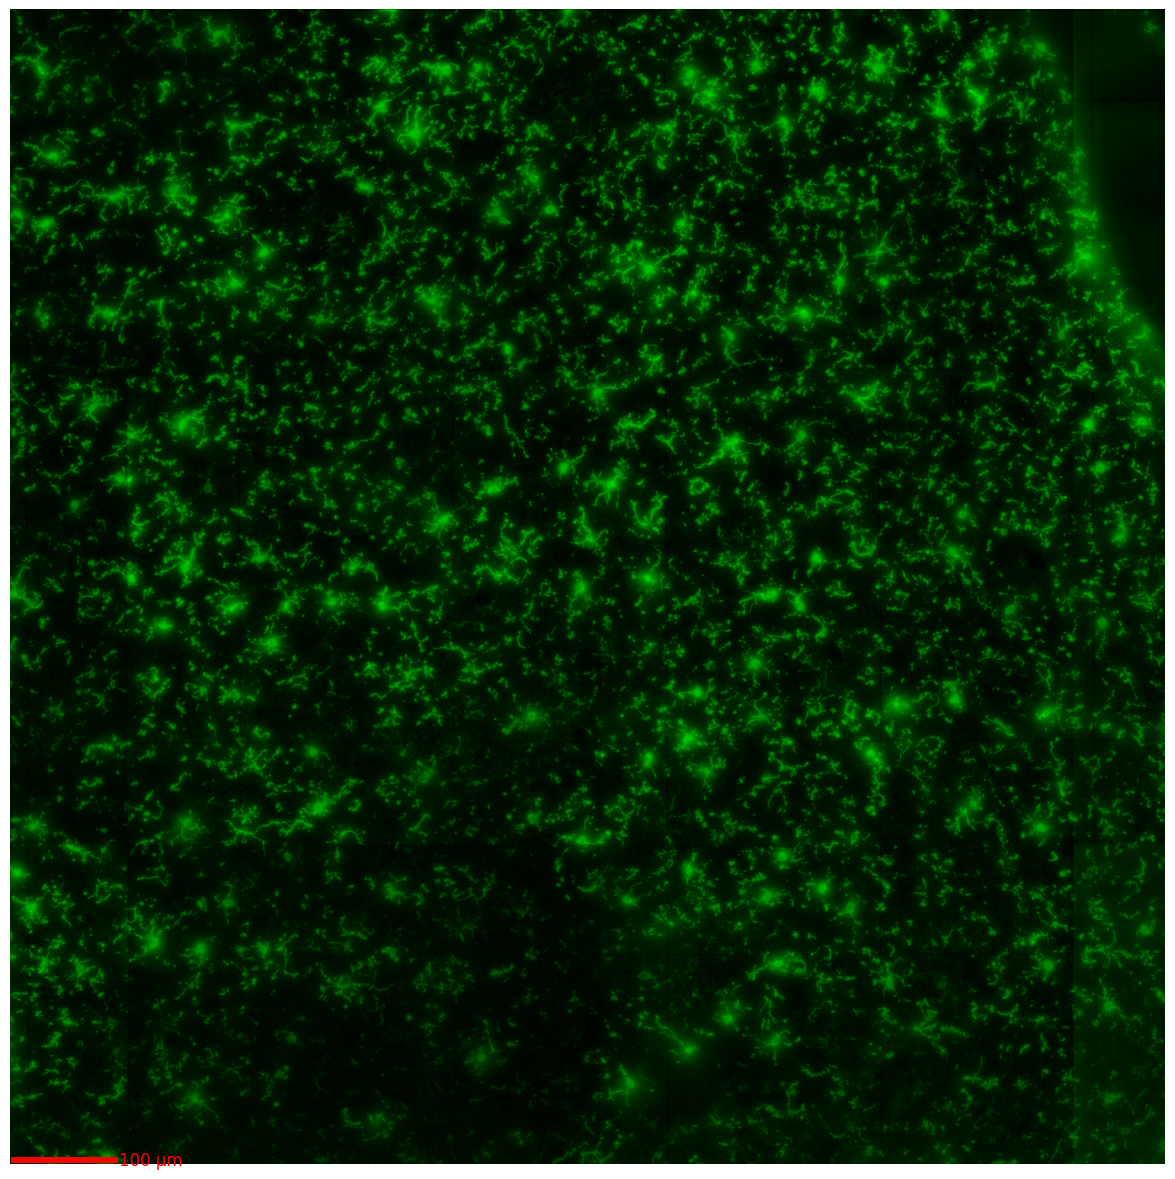

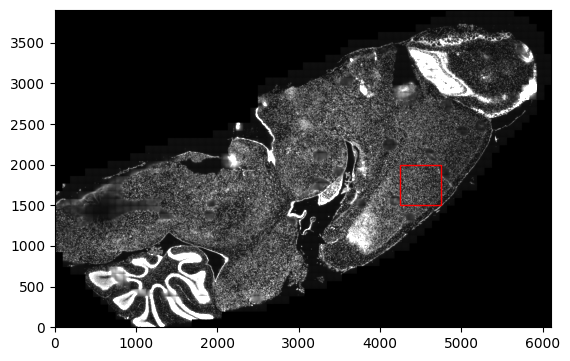

In [9]:
xMin = 85000
yMin = 30000
width = 10000
height = 10000
xMax = xMin + width
yMax = yMin + height
viewport = [xMin, yMin, width, height]

green = convert_eight_bit(load_image_roi(root + batch + '/binary_image.tif', viewport))
#red = convert_eight_bit(load_image_roi(polyt_file_name, viewport))
#green = convert_eight_bit(load_image_roi(mic_file_name, viewport))


print('Viewport created.')

fig, ax = plt.subplots(1,1, figsize=(15,15))
zero_im = np.zeros(green.shape, dtype=np.uint8)

#red = zero_im

# Sample MERFISH bit
#im = cv2.merge((red, zero_im, zero_im))
#ax[0].imshow(im, origin='lower')
#ax[0].axis("off")

# Positions of decoded transcripts + segmented boundaries
# CellBound3
im = cv2.merge((zero_im, green, zero_im))
ax.imshow(im, origin='lower')
ax.axis("off")


# DAPI
#im = cv2.merge((zero_im, zero_im, blue))
#ax[1,1].imshow(im, origin='lower')
#ax[1,1].axis("off")

#fig.savefig('SI_Figures/Baysor_example.pdf', format='pdf')
#ax.imshow(small_raw,cmap='gray')
add_scale_bar(ax, mosaic_to_micron, 100, color='red', location=(10, 10), thickness=50, fontsize=12)
plt.savefig('supp_figures/SI_3/Cortex_tight.pdf')
plt.show()

# Plot the mosaic image and show the window view
globMinX, globMinY = (xMin/dscale, yMin/dscale)
globMaxX, globMaxY = (xMax/dscale, yMax/dscale)

# Create rectangle for zoomed in snippet
rect = mpatches.Rectangle((globMinX, globMinY), globMaxX - globMinX, 
                          globMaxY - globMinY, linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots()
ax.imshow(mosaic_lowres, cmap='gray', vmax=20000, origin='lower')
ax.add_patch(rect)
plt.savefig('supp_figures/SI_3/Cortex_out.pdf')
plt.show()

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Viewport created.


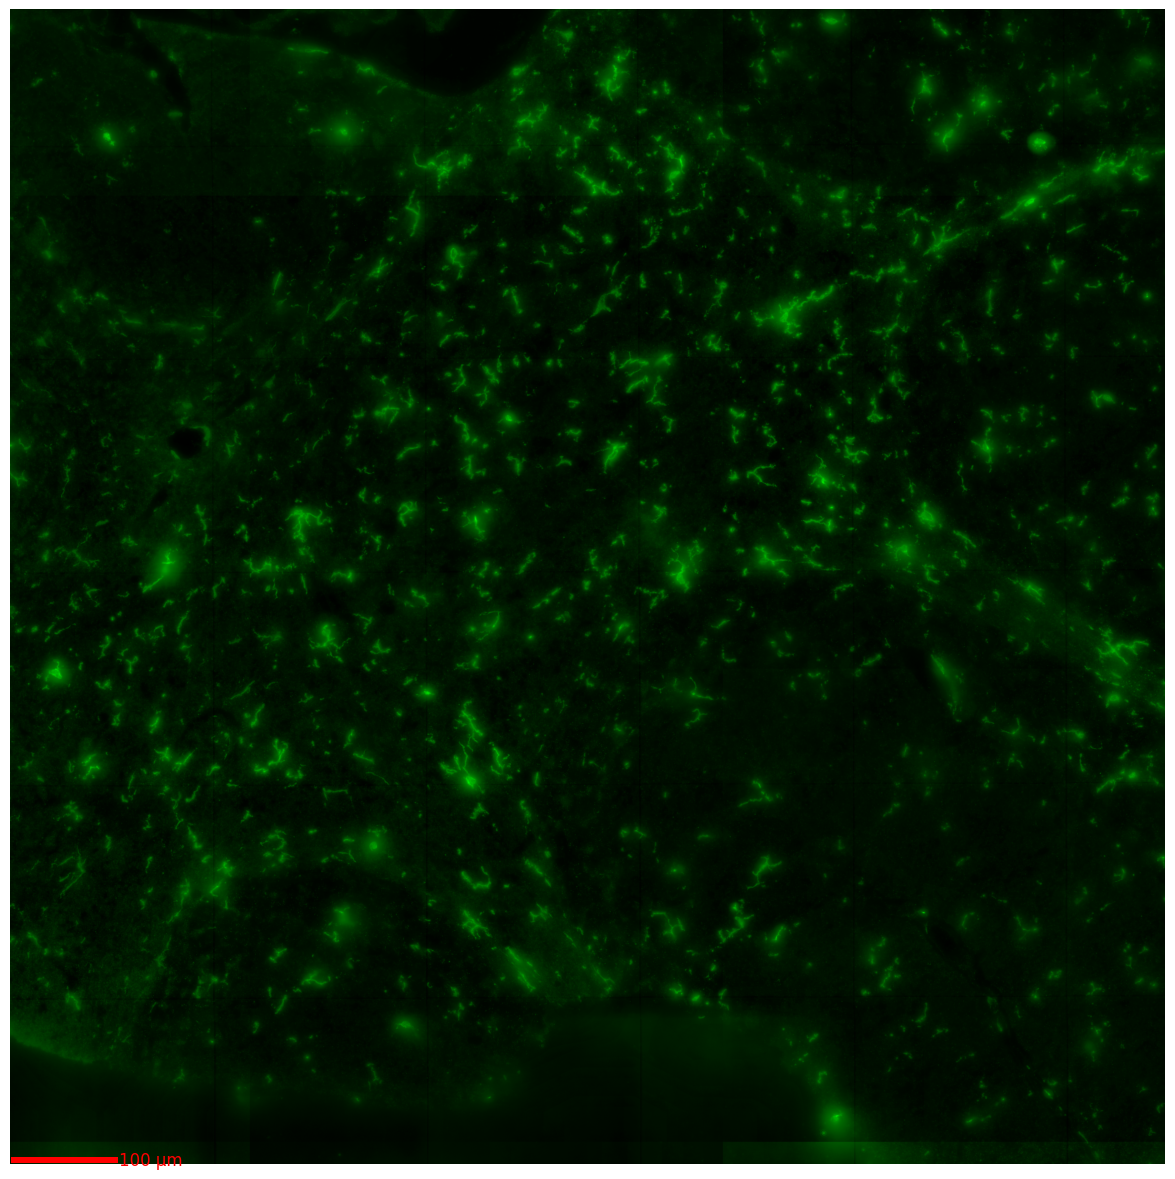

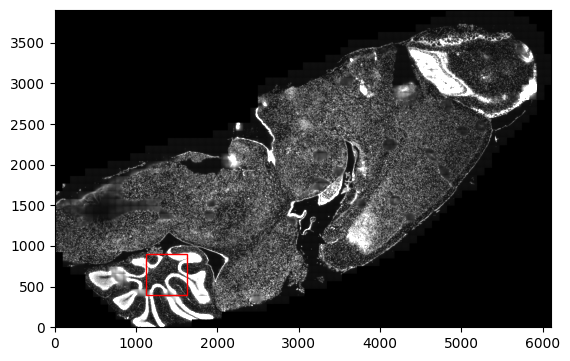

In [10]:
xMin = 22500
yMin = 8000
width = 10000
height = 10000
xMax = xMin + width
yMax = yMin + height
viewport = [xMin, yMin, width, height]

green = convert_eight_bit(load_image_roi(root + batch + '/binary_image.tif', viewport))
#red = convert_eight_bit(load_image_roi(polyt_file_name, viewport))
#green = convert_eight_bit(load_image_roi(mic_file_name, viewport))


print('Viewport created.')

fig, ax = plt.subplots(1,1, figsize=(15,15))
zero_im = np.zeros(green.shape, dtype=np.uint8)

#red = zero_im

# Sample MERFISH bit
#im = cv2.merge((red, zero_im, zero_im))
#ax[0].imshow(im, origin='lower')
#ax[0].axis("off")

# Positions of decoded transcripts + segmented boundaries
# CellBound3
im = cv2.merge((zero_im, green, zero_im))
ax.imshow(im, origin='lower')
ax.axis("off")


# DAPI
#im = cv2.merge((zero_im, zero_im, blue))
#ax[1,1].imshow(im, origin='lower')
#ax[1,1].axis("off")

#fig.savefig('SI_Figures/Baysor_example.pdf', format='pdf')
#ax.imshow(small_raw,cmap='gray')
add_scale_bar(ax, mosaic_to_micron, 100, color='red', location=(10, 10), thickness=50, fontsize=12)
plt.savefig('supp_figures/SI_3/CB_tight.pdf')
plt.show()

# Plot the mosaic image and show the window view
globMinX, globMinY = (xMin/dscale, yMin/dscale)
globMaxX, globMaxY = (xMax/dscale, yMax/dscale)

# Create rectangle for zoomed in snippet
rect = mpatches.Rectangle((globMinX, globMinY), globMaxX - globMinX, 
                          globMaxY - globMinY, linewidth=1, edgecolor='r', facecolor='none')

fig, ax = plt.subplots()
ax.imshow(mosaic_lowres, cmap='gray', vmax=20000, origin='lower')
ax.add_patch(rect)
plt.savefig('supp_figures/SI_3/CB_out.pdf')
plt.show()

In [11]:
from scipy.stats import sem
def plot_stacked_bar_by_age(adata, age_column='Age', sub_mic_column='sub_mic',output_pdf=None):
    """
    Plot a stacked bar plot showing the percentage of each sub_mic category at each age.
    
    Parameters:
    - adata: AnnData object with `Age` and `sub_mic` information in `.obs`.
    - age_column: The column in `adata.obs` that represents the age (default is 'Age').
    - sub_mic_column: The column in `adata.obs` that represents the sub_mic categories (default is 'sub_mic').
    
    Returns:
    - A stacked bar plot showing the percentage of each sub_mic category at each age.
    """
    # Create a DataFrame with Age and sub_mic information
    df = adata.obs[[age_column, sub_mic_column]]
    
    # Group by Age and sub_mic and count occurrences
    grouped = df.groupby([age_column, sub_mic_column]).size().unstack(fill_value=0)
    
    # Calculate the percentage for each sub_mic category by age
    percentage_df = grouped.div(grouped.sum(axis=1), axis=0) * 100

    # Plot the stacked bar plot
    percentage_df.plot(kind='bar', stacked=True, figsize=(6, 6), cmap='tab20')

    # Customize the plot
    plt.title('Percentage of each sub_mic by Age')
    plt.xlabel('Age')
    plt.ylabel('Percentage')
    plt.legend(title=sub_mic_column, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    if output_pdf:
        plt.savefig(output_pdf,format='pdf')

    # Show the plot
    plt.show()
    
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem, wilcoxon
from itertools import combinations

def plot_and_export_density_with_stats(adata, adata_total, sub_mic_value, region_column='Brain_Region', age_column='Age', batch_column='batchID', sub_mic_column='sub_mic', output_pdf=None):
    """
    Plot density of a specific sub_mic category and perform pairwise Wilcoxon signed-rank tests between region-age pairs.
    
    Parameters:
    - adata: AnnData object with subset of cells for the sub_mic category.
    - adata_total: AnnData object with all cells for density calculations.
    - sub_mic_value: Specific sub_mic category to analyze.
    - region_column, age_column, batch_column, sub_mic_column: Column names in `.obs`.
    - output_pdf: Path to save plot as a PDF.
    
    Returns:
    - stats_df: DataFrame with density values for plotting.
    - wilcoxon_df: DataFrame with pairwise Wilcoxon signed-rank test results.
    """
    # Filter for cells matching sub_mic_value and get counts by region, age, and batch
    df = adata.obs[[region_column, age_column, batch_column, sub_mic_column]]
    sub_mic_df = df[df[sub_mic_column] == sub_mic_value]
    sub_mic_counts_by_region = sub_mic_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='sub_mic_counts')
    
    # Total cell counts from adata_total for each region, age, and batch
    total_df = adata_total.obs[[region_column, age_column, batch_column]]
    total_counts_by_region = total_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='total_counts')

    # Merge sub_mic counts with total counts and calculate density
    merged_df = pd.merge(sub_mic_counts_by_region, total_counts_by_region, on=[region_column, age_column, batch_column], how='left')
    merged_df['Density'] = merged_df['sub_mic_counts'] / merged_df['total_counts']

    # Calculate mean and SEM for each region and age
    stats_df = merged_df.groupby([region_column, age_column]).agg(
        mean_density=('Density', 'mean'),
        sem_density=('Density', sem)
    ).reset_index()

    # Plot density by region and age
    plt.figure(figsize=(8, 6))
    sns.barplot(data=merged_df, x=region_column, y='Density', hue=age_column, palette='Set2', capsize=0.1, errorbar='se')
    sns.stripplot(data=merged_df, x=region_column, y='Density', hue=age_column, dodge=True, jitter=True, marker='o', palette='dark', size=5, alpha=0.7)
    plt.title(f'Density of {sub_mic_value} in Each Region by Age (Relative to Total Cell Count)')
    plt.xlabel('Region')
    plt.ylabel('Density of Cell Type')
    plt.legend(title='Age')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    if output_pdf:
        plt.savefig(output_pdf, format='pdf')
    plt.show()

    # Perform pairwise Wilcoxon signed-rank tests between each pair of region-age groups
    pairwise_results = []
    merged_df['Density'] = merged_df['Density'].fillna(0)
    unique_pairs = list(combinations(merged_df[[region_column, age_column]].drop_duplicates().itertuples(index=False, name=None), 2))

    for (region1, age1), (region2, age2) in unique_pairs:
        # Extract density values for the two groups
        density_group1 = merged_df[(merged_df[region_column] == region1) & (merged_df[age_column] == age1)]['Density']
        density_group2 = merged_df[(merged_df[region_column] == region2) & (merged_df[age_column] == age2)]['Density']
        
        # Ensure they have matching batch counts for paired testing
        shared_batches = set(merged_df[merged_df[region_column] == region1][batch_column]) & set(merged_df[merged_df[region_column] == region2][batch_column])
        density_group1 = density_group1[merged_df[batch_column].isin(shared_batches)]
        density_group2 = density_group2[merged_df[batch_column].isin(shared_batches)]
        
        # Only conduct test if both groups have values and at least two shared batches
        if len(density_group1) > 1 and len(density_group2) > 1:
            stat, p_value = wilcoxon(density_group1, density_group2)
            pairwise_results.append({
                'Region_Age_1': f"{region1}_{age1}",
                'Region_Age_2': f"{region2}_{age2}",
                'Wilcoxon_statistic': stat,
                'p_value': p_value
            })

    # Convert results to DataFrame
    wilcoxon_df = pd.DataFrame(pairwise_results)
    return stats_df, wilcoxon_df

In [12]:
new_ad = new_ad[new_ad.obs.Brain_Region != 'Unlabeled']

/tmp/ipykernel_1436188/2391171977.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby([age_column, sub_mic_column]).size().unstack(fill_value=0)


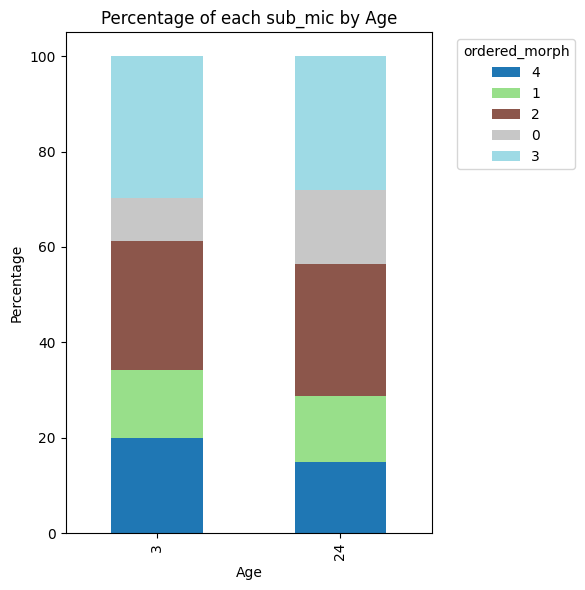

In [13]:
plot_stacked_bar_by_age(new_ad, age_column='Age', sub_mic_column='ordered_morph',output_pdf='stacked_bar_morph_by_age.pdf')

/tmp/ipykernel_1436188/2391171977.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sub_mic_counts_by_region = sub_mic_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='sub_mic_counts')
/tmp/ipykernel_1436188/2391171977.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts_by_region = total_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='total_counts')
/tmp/ipykernel_1436188/2391171977.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

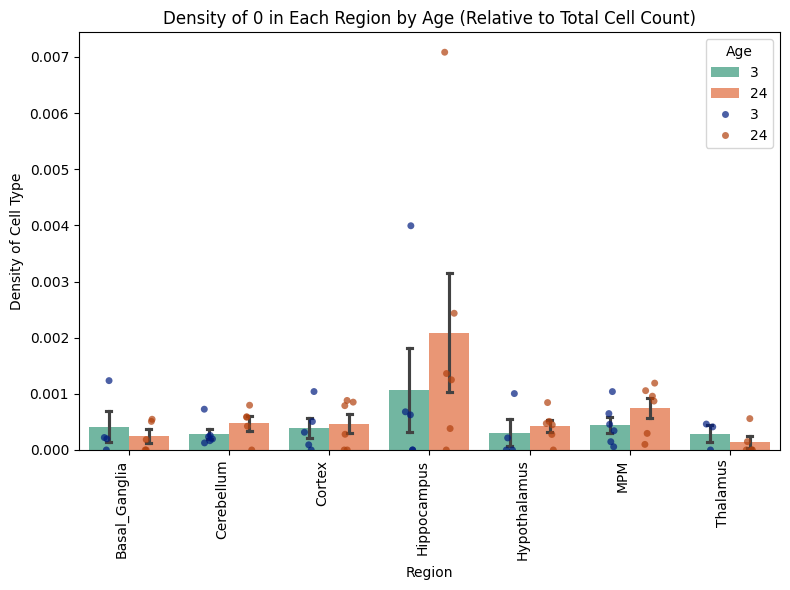

Region_Age_1     Region_Age_2  Wilcoxon_statistic   p_value
18  Basal_Ganglia_24   Hippocampus_24                 0.0  0.043114
22  Basal_Ganglia_24           MPM_24                 0.0  0.027708
39     Cerebellum_24   Hippocampus_24                 0.0  0.043114
43     Cerebellum_24           MPM_24                 0.0  0.027708
56         Cortex_24   Hippocampus_24                 0.0  0.043114
60         Cortex_24           MPM_24                 0.0  0.027708
71    Hippocampus_24  Hypothalamus_24                 1.0  0.046399
75    Hippocampus_24      Thalamus_24                 0.0  0.043114
82   Hypothalamus_24           MPM_24                 1.0  0.046399
86             MPM_3       Thalamus_3                 1.0  0.046399
89            MPM_24      Thalamus_24                 0.0  0.027708

In [14]:
_, pvals = plot_and_export_density_with_stats(new_ad,total, '0', region_column='Brain_Region', age_column='Age', batch_column='batchID', sub_mic_column='ordered_morph',output_pdf='morph_0_density.pdf')
pvals[pvals.p_value < 0.05]

/tmp/ipykernel_1436188/2391171977.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sub_mic_counts_by_region = sub_mic_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='sub_mic_counts')
/tmp/ipykernel_1436188/2391171977.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts_by_region = total_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='total_counts')
/tmp/ipykernel_1436188/2391171977.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

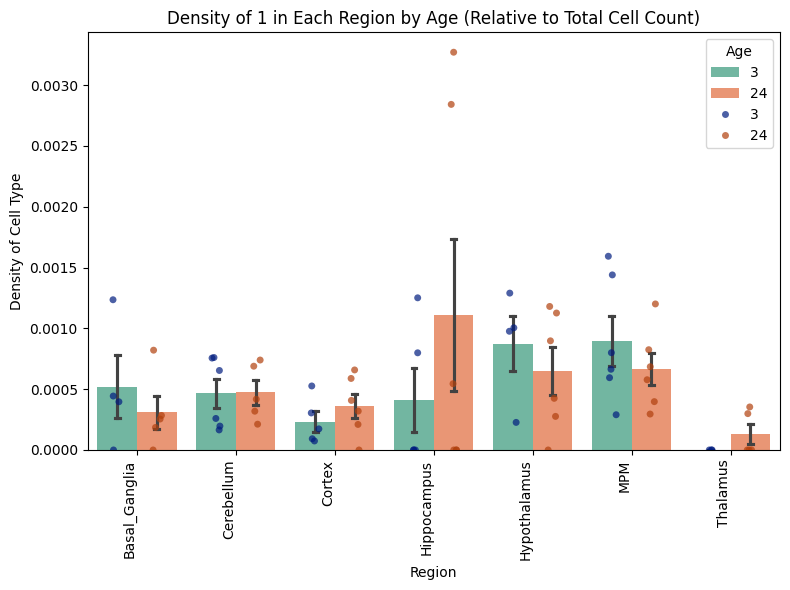

Region_Age_1 Region_Age_2  Wilcoxon_statistic   p_value
32     Cerebellum_3        MPM_3                 0.0  0.027708
34     Cerebellum_3   Thalamus_3                 0.0  0.027708
43    Cerebellum_24       MPM_24                 1.0  0.046399
44    Cerebellum_24   Thalamus_3                 0.0  0.043114
51         Cortex_3        MPM_3                 1.0  0.046399
53         Cortex_3   Thalamus_3                 0.0  0.043114
60        Cortex_24       MPM_24                 1.0  0.046399
61        Cortex_24   Thalamus_3                 0.0  0.043114
83  Hypothalamus_24   Thalamus_3                 0.0  0.043114
86            MPM_3   Thalamus_3                 0.0  0.027708
88           MPM_24   Thalamus_3                 0.0  0.027708
89           MPM_24  Thalamus_24                 1.0  0.046399

In [15]:
_, pvals = plot_and_export_density_with_stats(new_ad,total, '1', region_column='Brain_Region', age_column='Age', batch_column='batchID', sub_mic_column='ordered_morph',output_pdf='morph_1_density.pdf')
pvals[pvals.p_value < 0.05]

/tmp/ipykernel_1436188/2391171977.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sub_mic_counts_by_region = sub_mic_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='sub_mic_counts')
/tmp/ipykernel_1436188/2391171977.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts_by_region = total_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='total_counts')
/tmp/ipykernel_1436188/2391171977.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

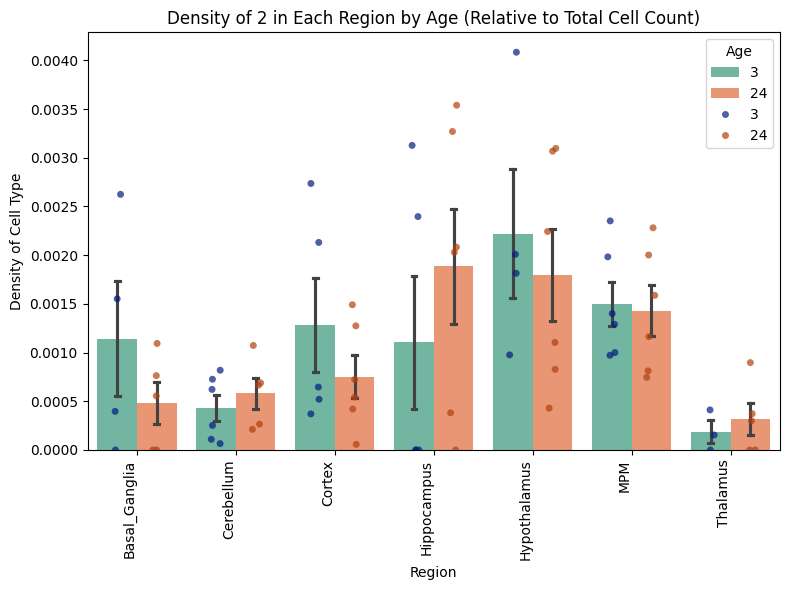

Region_Age_1     Region_Age_2  Wilcoxon_statistic   p_value
18  Basal_Ganglia_24   Hippocampus_24                 0.0  0.043114
20  Basal_Ganglia_24  Hypothalamus_24                 0.0  0.027708
22  Basal_Ganglia_24           MPM_24                 0.0  0.027708
32      Cerebellum_3            MPM_3                 0.0  0.027708
41     Cerebellum_24  Hypothalamus_24                 1.0  0.046399
43     Cerebellum_24           MPM_24                 1.0  0.046399
53          Cortex_3       Thalamus_3                 0.0  0.043114
58         Cortex_24  Hypothalamus_24                 0.0  0.027708
75    Hippocampus_24      Thalamus_24                 0.0  0.043114
83   Hypothalamus_24       Thalamus_3                 3.0  0.035692
84   Hypothalamus_24      Thalamus_24                 0.0  0.027708
86             MPM_3       Thalamus_3                 0.0  0.027708
88            MPM_24       Thalamus_3                 3.0  0.035692
89            MPM_24      Thalamus_24                 0.0  0.027708

In [16]:
_, pvals = plot_and_export_density_with_stats(new_ad,total, '2', region_column='Brain_Region', age_column='Age', batch_column='batchID', sub_mic_column='ordered_morph',output_pdf='morph_2_density.pdf')
pvals[pvals.p_value < 0.05]

/tmp/ipykernel_1436188/2391171977.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sub_mic_counts_by_region = sub_mic_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='sub_mic_counts')
/tmp/ipykernel_1436188/2391171977.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts_by_region = total_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='total_counts')
/tmp/ipykernel_1436188/2391171977.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

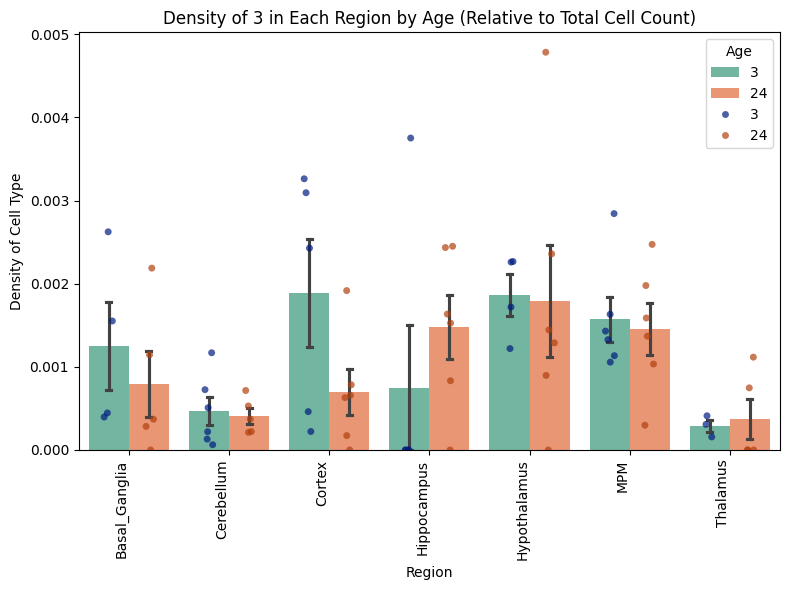

Region_Age_1     Region_Age_2  Wilcoxon_statistic   p_value
3    Basal_Ganglia_3         Cortex_3                 0.0  0.043114
20  Basal_Ganglia_24  Hypothalamus_24                 1.0  0.046399
32      Cerebellum_3            MPM_3                 0.0  0.027708
43     Cerebellum_24           MPM_24                 1.0  0.046399
53          Cortex_3       Thalamus_3                 0.0  0.043114
58         Cortex_24  Hypothalamus_24                 0.0  0.043114
86             MPM_3       Thalamus_3                 0.0  0.027708
87             MPM_3      Thalamus_24                 4.0  0.049950
89            MPM_24      Thalamus_24                 0.0  0.027708

In [17]:
_, pvals = plot_and_export_density_with_stats(new_ad,total, '3', region_column='Brain_Region', age_column='Age', batch_column='batchID', sub_mic_column='ordered_morph',output_pdf='morph_3_density.pdf')
pvals[pvals.p_value < 0.05]

/tmp/ipykernel_1436188/2391171977.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sub_mic_counts_by_region = sub_mic_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='sub_mic_counts')
/tmp/ipykernel_1436188/2391171977.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts_by_region = total_df.groupby([region_column, age_column, batch_column]).size().reset_index(name='total_counts')
/tmp/ipykernel_1436188/2391171977.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

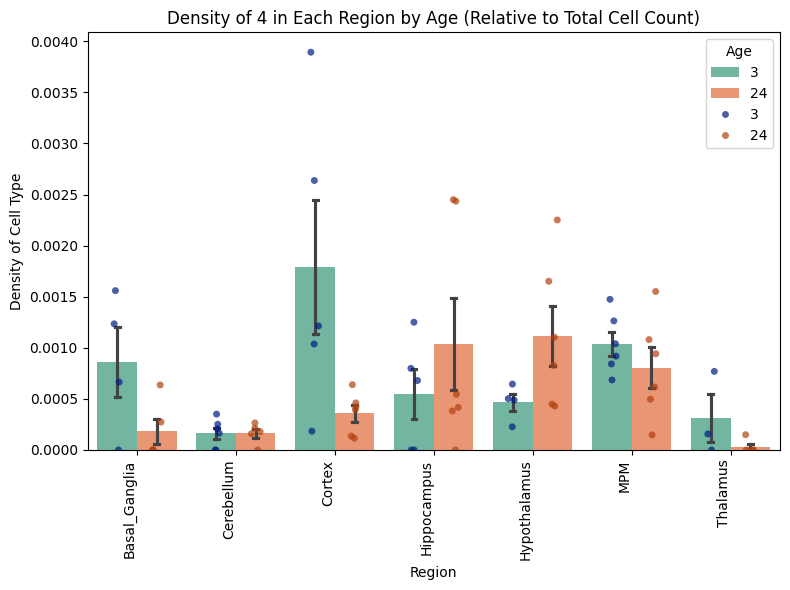

Region_Age_1     Region_Age_2  Wilcoxon_statistic   p_value
18  Basal_Ganglia_24   Hippocampus_24                 0.0  0.043114
20  Basal_Ganglia_24  Hypothalamus_24                 0.0  0.027708
21  Basal_Ganglia_24            MPM_3                 3.0  0.035692
22  Basal_Ganglia_24           MPM_24                 0.0  0.027708
32      Cerebellum_3            MPM_3                 0.0  0.027708
37     Cerebellum_24        Cortex_24                 1.0  0.046399
39     Cerebellum_24   Hippocampus_24                 1.0  0.046399
41     Cerebellum_24  Hypothalamus_24                 0.0  0.027708
43     Cerebellum_24           MPM_24                 0.0  0.027708
53          Cortex_3       Thalamus_3                 0.0  0.043114
54          Cortex_3      Thalamus_24                 1.0  0.046399
58         Cortex_24  Hypothalamus_24                 0.0  0.027708
60         Cortex_24           MPM_24                 0.0  0.027708
62         Cortex_24      Thalamus_24                 0.0  0.027708
75    Hippocampus_24      Thalamus_24                 0.0  0.043114
77    Hypothalamus_3            MPM_3                 0.0  0.027708
84   Hypothalamus_24      Thalamus_24                 0.0  0.027708
86             MPM_3       Thalamus_3                 0.0  0.027708
87             MPM_3      Thalamus_24                 1.0  0.027992
89            MPM_24      Thalamus_24                 0.0  0.027708

In [18]:
_, pvals = plot_and_export_density_with_stats(new_ad,total, '4', region_column='Brain_Region', age_column='Age', batch_column='batchID', sub_mic_column='ordered_morph',output_pdf='morph_4_density.pdf')
pvals[pvals.p_value < 0.05]